In [1092]:
import os
import skimage
from skimage import feature, transform, filters, morphology
import skimage.transform.hough_transform as ht
import numpy as np
import numpy.linalg as lin
import math

import matplotlib.pyplot as plt
import ipywidgets as widgets

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Load images
Also contains approximate transform to grayscale (i.e. just take the green channel)

In [980]:
files = os.listdir("images")
imsize = (1008, 3038//4)
images = np.zeros((len(files), imsize[0],imsize[1]))
i = 0
for name in files: 
    tmp = skimage.io.imread(os.path.join("images", name))
    images[i] = transform.resize(tmp, (imsize), anti_aliasing=True)[:,:,1]
    i += 1
    print("done loading image",i)

done loading image 1
done loading image 2
done loading image 3
done loading image 4
done loading image 5
done loading image 6
done loading image 7
done loading image 8
done loading image 9
done loading image 10
done loading image 11
done loading image 12
done loading image 13
done loading image 14
done loading image 15
done loading image 16
done loading image 17
done loading image 18
done loading image 19
done loading image 20
done loading image 21


In [981]:
def calc_edges(image):
    return feature.canny(skimage.img_as_float(image), sigma=5, high_threshold=0.95, low_threshold=0.1, use_quantiles=True)

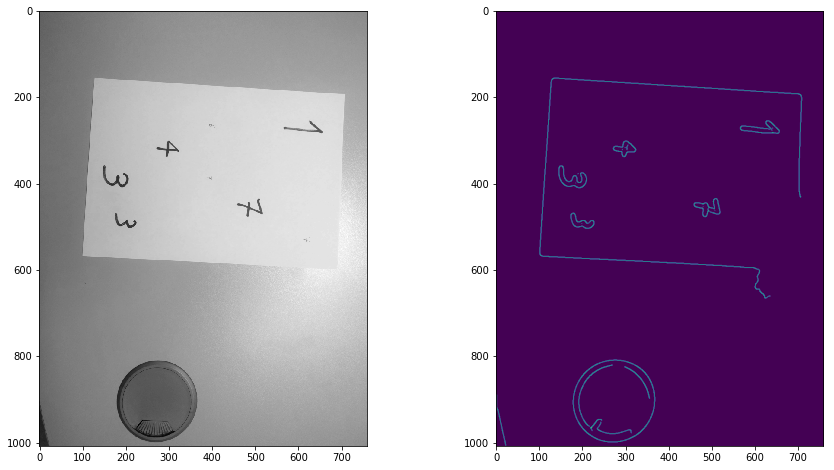

In [982]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
image = images[20]
ax0.imshow(image, cmap="gray")
ax1.imshow(calc_edges(image), interpolation='bilinear')

## Preprocessing for a single image

In [1050]:
def get_angle(l0, l1):
    dot = np.dot(l0, l1)
    return np.arccos(dot/(lin.norm(l0)* lin.norm(l1)))

def get_intersection(l0, l1):
    lab = np.cross(l0[0], l0[1])
    lcd = np.cross(l1[0], l1[1])
    i = np.cross(lab, lcd)
    i = i / i[2]
    return i[0:2]


def get_adjacent(line, opline,  llines):
    lab = np.cross(llines[line,0], llines[line,1])
    lxy = np.cross(llines[opline, 0], llines[opline, 1])
    
    for i in range(0, llines.shape[0]):
        if not i == l and not i == opline:
            lcd = np.cross(llines[i, 0], llines[i,1])
            angle_ac = np.abs(np.degrees(get_angle(lab[0:2], lcd[0:2])))
            angle_xc = np.abs(np.degrees(get_angle(lxy[0:2], lcd[0:2])))
            if angle_ac > 25 and angle_xc > 25:
                return i

def get_opposite(l, llines):
    lab = np.cross(llines[l, 0], llines[l, 1])
    for i in range(0, llines.shape[0]):
        if not i == l:
            lac = np.cross(llines[l, 0], llines[i,0])
            lcd = np.cross(llines[i, 0], llines[i,1])
            distance = np.abs(lin.norm(np.cross(lab, lac)) / lin.norm(lab))
            angle = get_angle(lab[0:2], lcd[0:2])
            angle = np.abs(np.degrees(angle))

            #if angle is smaller than 25 degrees and distance larger than 50 pixels, we found the opposite
            if angle < 30 and distance > 50:
                return i
            
def flip_to_lower_left(i, j, dim, sorted_lines):
    minI = min(sorted_lines[i, :, dim])
    minJ = min(sorted_lines[j, :, dim])
    if minI > minJ:
        tmp = sorted_lines[i].copy()
        sorted_lines[i] = sorted_lines[j]
        sorted_lines[j] = tmp
    return sorted_lines

In [1085]:
image = images[2]
edges = calc_edges(image)

In [1086]:
lines = transform.probabilistic_hough_line(edges, threshold=100, line_length=150, line_gap=100)
len(lines)

10

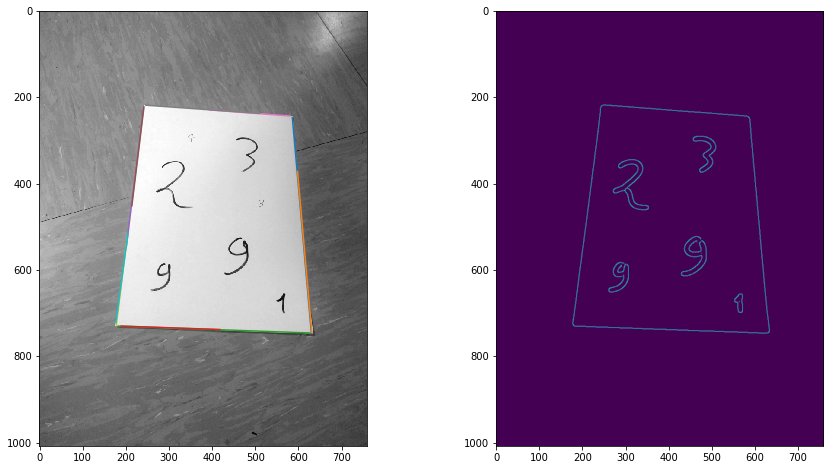

In [1087]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(image, cmap="gray")
ax1.imshow(edges, interpolation='bilinear')
for ((x0,y0),(x1,y1)) in lines:
    ax0.plot([x0,x1],[y0,y1])

In [1088]:
llines = np.ones((len(lines),2,3))
llines[:, :, 0:2] = np.asarray(lines)

sorted_lines = np.ones((4,2,3))
sorted_lines[0] = llines[0]
op = get_opposite(0, llines)
sorted_lines[2] = llines[op]
adjacent = get_adjacent(0, op, llines)
sorted_lines[1] = llines[adjacent]
adjacent_op = get_opposite(adjacent, llines)
sorted_lines[3]= llines[adjacent_op]
sorted_lines = flip_to_lower_left(0, 2, 0, sorted_lines)
sorted_lines = flip_to_lower_left(0, 2, 1, sorted_lines)
sorted_lines = flip_to_lower_left(3, 1, 0, sorted_lines)
sorted_lines = flip_to_lower_left(3, 1, 1, sorted_lines)

intersections = np.zeros((4, 2))
intersections[0] = get_intersection(sorted_lines[0],sorted_lines[1])
intersections[1] = get_intersection(sorted_lines[1],sorted_lines[2])
intersections[2] = get_intersection(sorted_lines[2],sorted_lines[3])
intersections[3] = get_intersection(sorted_lines[3],sorted_lines[0])
rounded = np.round(intersections)
print(rounded)

[[178. 730.]
 [630. 746.]
 [586. 243.]
 [242. 218.]]


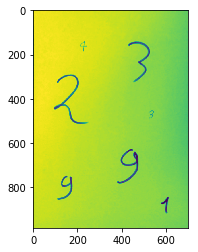

In [1089]:
w,h = 700, round(700*1.404)
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])

c = np.asarray([
    intersections[0],
    intersections[1],
    intersections[2],
    intersections[3]
])

tf = transform.estimate_transform("projective",
                                  src = rounded,
                                  dst=np.vstack((A,B,C,D)))
page = skimage.transform.warp(image=image, inverse_map=tf.inverse, output_shape=(h,w))
plt.imshow(page)

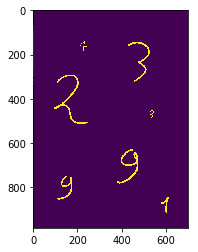

In [1090]:
page = skimage.img_as_float(page)
binary = page < filters.threshold_local(page, 51, mode='reflect', offset=0.05)
plt.imshow(binary)

In [1075]:
labels = skimage.measure.label(binary)
rp = skimage.measure.regionprops(labels)
regions = [r for r in rp if r.area > 80 and r.bbox[0] + r.bbox[2] > 10 and  r.bbox[1] + r.bbox[3] > 10 ]
print(len(regions))

8


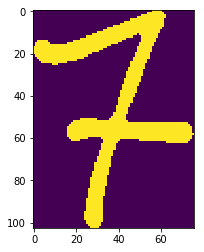

In [1076]:
i =2
plt.imshow(regions[i].image)

In [709]:
print(len(regions))

7


# MNIST Training

In [1112]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

In [1126]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
xr1 = np.rot90(x_train, axes=(1,2))
xtr1 = np.rot90(x_test, axes=(1,2))
xr2 = np.rot90(xr1, axes=(1,2))
xtr2 = np.rot90(xtr1, axes=(1,2))
xr3 = np.rot90(xr2, axes=(1,2))
xtr3 = np.rot90(xtr2, axes=(1,2))

x_train_full = np.vstack((x_train, xr1, xr2, xr3))
y_train_full = np.concatenate((y_train, y_train, y_train, y_train))

x_test_full = np.vstack((x_test, xtr1, xtr2, xtr3))
y_test_full = np.concatenate((y_test, y_test,y_test,y_test))

In [1132]:
if K.image_data_format() == 'channels_first':
    x_train = x_train_full.reshape(x_train_full.shape[0], 1, img_rows, img_cols)
    x_test = x_test_full.reshape(x_test_full.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train_full.reshape(x_train_full.shape[0], img_rows, img_cols, 1)
    x_test = x_test_full.reshape(x_test_full.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_full, num_classes)
y_test = keras.utils.to_categorical(y_test_full, num_classes)

x_train shape: (240000, 28, 28, 1)
240000 train samples
40000 test samples


In [1133]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))



Instructions for updating:
Use tf.cast instead.
Train on 240000 samples, validate on 40000 samples
Epoch 1/12
240000/240000 [==============================] - 1000s 4ms/step - loss: 0.3721 - acc: 0.8828 - val_loss: 0.1100 - val_acc: 0.9665
Epoch 2/12
240000/240000 [==============================] - 1023s 4ms/step - loss: 0.1810 - acc: 0.9458 - val_loss: 0.0876 - val_acc: 0.9726
Epoch 3/12
240000/240000 [==============================] - 909s 4ms/step - loss: 0.1552 - acc: 0.9540 - val_loss: 0.0771 - val_acc: 0.9763
Epoch 4/12
240000/240000 [==============================] - 970s 4ms/step - loss: 0.1411 - acc: 0.9591 - val_loss: 0.0745 - val_acc: 0.9778
Epoch 5/12
233600/240000 [============================>.] - ETA: 24s - loss: 0.1334 - acc: 0.9613

In [1107]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(120000, 28, 28)

In [1122]:
model.save("mnist_model")

(4, 60000, 10)

# Full algorithm